# ision Transformer (ViT) for Image Classification

## Objective
In this part, we explore the application of Transformer architectures in Computer Vision. We perform the following tasks using the **MNIST** dataset (handwritten digits):

1.  **Vision Transformer (ViT):** Fine-tune a pre-trained ViT model.
2.  **Simple CNN:** Implement and train a traditional Convolutional Neural Network from scratch.
3.  **Comparison:** Compare both models in terms of **Accuracy** and **Training Time**.

## Dataset
- **Name:** MNIST
- **Content:** 28x28 Grayscale images of digits (0-9).
- **Preprocessing:**
    - For ViT: Resized to 224x224 and converted to 3 channels (RGB) to match the pre-trained model input.
    - For CNN: Kept as 28x28 (Grayscale).
    - All images are normalized to range [0, 1].



---



# Data Preparation and Preprocessing
In this step, we prepare the environment and load the MNIST dataset. Since we are comparing two different architectures, we apply distinct preprocessing pipelines:

*   For ViT: Images are resized to 224x224 and converted to 3 channels (RGB) to match the input requirements of the pre-trained Vision Transformer.
*   For CNN: Images are kept in their original 28x28 Grayscale format.

We also select a fixed subset of the data (4,000 training samples) to ensure the training process completes within a reasonable time on Google Colab.

In [ ]:
# Setup and Data Loading

# Install necessary libraries (Clean version)
!pip install transformers torchvision scikit-learn matplotlib seaborn #accelerate

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTImageProcessor, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np

In [ ]:
# Check Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Preparation for ViT (224x224, 3 Channels)
print("Preparing data for ViT...")
# ViT requires larger images (224x224) and RGB (3 channels)
vit_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3), # Convert 1 channel to 3
    transforms.ToTensor(),
])

# Load Datasets
vit_train_full = datasets.MNIST(root='./data', train=True, download=True, transform=vit_transform)
vit_test_full = datasets.MNIST(root='./data', train=False, download=True, transform=vit_transform)

# SUBSET: Use a smaller subset to speed up training in Colab
# use 4000 for training and 1000 for testing
subset_indices_train = range(4000)
subset_indices_test = range(1000)

vit_train_ds = torch.utils.data.Subset(vit_train_full, subset_indices_train)
vit_test_ds = torch.utils.data.Subset(vit_test_full, subset_indices_test)

print(f"ViT Training Samples: {len(vit_train_ds)}")
print(f"ViT Test Samples: {len(vit_test_ds)}")

# Data Preparation for CNN (28x28, 1 Channel)
print("Preparing data for CNN...")
# CNN can handle the original small size
cnn_transform = transforms.Compose([
    transforms.ToTensor()
])

cnn_train_full = datasets.MNIST(root='./data', train=True, download=True, transform=cnn_transform)
cnn_test_full = datasets.MNIST(root='./data', train=False, download=True, transform=cnn_transform)

# Use SAME subset indices for fair comparison
cnn_train_ds = torch.utils.data.Subset(cnn_train_full, subset_indices_train)
cnn_test_ds = torch.utils.data.Subset(cnn_test_full, subset_indices_test)

# DataLoaders for CNN
cnn_train_loader = torch.utils.data.DataLoader(cnn_train_ds, batch_size=64, shuffle=True)
cnn_test_loader = torch.utils.data.DataLoader(cnn_test_ds, batch_size=64, shuffle=False)

print(f"CNN Training Samples: {len(cnn_train_ds)}")

Using device: cpu
Preparing data for ViT...


100%|██████████| 9.91M/9.91M [00:00<00:00, 22.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 621kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.64MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.98MB/s]


ViT Training Samples: 4000
ViT Test Samples: 1000
Preparing data for CNN...
CNN Training Samples: 4000




---



# Fine-Tuning Vision Transformer (ViT)
Here, we leverage Transfer Learning by loading a pre-trained Vision Transformer (google/vit-base-patch16-224-in21k). We modify the classification head to output 10 classes (for digits 0-9) and fine-tune the model for 3 epochs. This approach allows the model to utilize features learned from the massive ImageNet dataset.

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.238700,0.146113,0.976000
2,0.081400,0.110696,0.979000
3,0.033700,0.086794,0.981000


ViT Training Time: 441.03 seconds
Evaluating ViT...


ViT Accuracy: 0.9810

Classification Report (ViT):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        85
           1       1.00      1.00      1.00       126
           2       0.99      0.96      0.97       116
           3       1.00      0.96      0.98       107
           4       0.97      0.99      0.98       110
           5       0.96      0.99      0.97        87
           6       0.99      0.99      0.99        87
           7       0.94      1.00      0.97        99
           8       0.99      0.97      0.98        89
           9       0.98      0.96      0.97        94

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



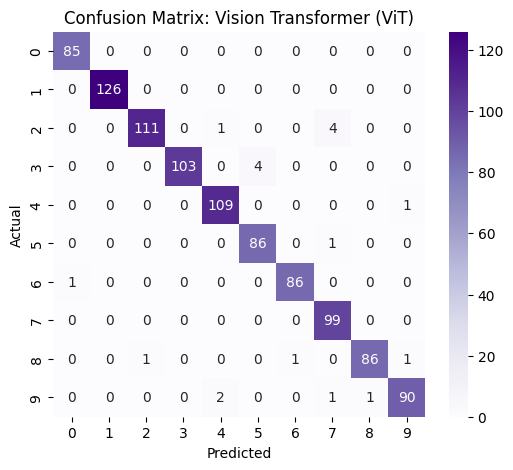

In [ ]:
# Train Vision Transformer (ViT)

# Model Setup
model_checkpoint = 'google/vit-base-patch16-224-in21k'

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x[0] for x in batch]),
        'labels': torch.tensor([x[1] for x in batch])
    }

# Load Model with Correct Label Mappings
model_vit = ViTForImageClassification.from_pretrained(
    model_checkpoint,
    num_labels=10,
    id2label={i: str(i) for i in range(10)},
    label2id={str(i): i for i in range(10)}
)

# Metric function
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    acc = accuracy_score(labels, pred)
    return {"accuracy": acc}

# Training Arguments
training_args = TrainingArguments(
    output_dir="./vit-mnist-results",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=50,
    learning_rate=2e-4,
    remove_unused_columns=False,
    report_to="none"
)

# Trainer
trainer = Trainer(
    model=model_vit,
    args=training_args,
    train_dataset=vit_train_ds,
    eval_dataset=vit_test_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
)

# Train
start_time = time.time()
trainer.train()
end_time = time.time()
vit_time = end_time - start_time
print(f"ViT Training Time: {vit_time:.2f} seconds")

# Evaluate
print("Evaluating ViT...")
predictions = trainer.predict(vit_test_ds)
vit_preds = np.argmax(predictions.predictions, axis=1)
vit_labels = predictions.label_ids

vit_acc = accuracy_score(vit_labels, vit_preds)
print(f"ViT Accuracy: {vit_acc:.4f}")

# Visualizations
print("\nClassification Report (ViT):")
print(classification_report(vit_labels, vit_preds))

cm_vit = confusion_matrix(vit_labels, vit_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_vit, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix: Vision Transformer (ViT)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



---



# Training a Simple CNN Baseline
To establish a performance baseline, we implement and train a lightweight Convolutional Neural Network (CNN) from scratch. The architecture consists of a single convolutional layer followed by max-pooling and a fully connected layer. This represents a traditional, computationally efficient approach for simple image classification tasks.

Starting CNN Training...
CNN Training Time: 3.76 seconds
CNN Accuracy: 0.9150

Classification Report (CNN):
              precision    recall  f1-score   support

           0       0.92      0.99      0.95        85
           1       0.99      0.98      0.99       126
           2       0.95      0.91      0.93       116
           3       0.98      0.85      0.91       107
           4       0.80      0.99      0.88       110
           5       0.95      0.85      0.90        87
           6       0.92      0.93      0.93        87
           7       0.91      0.90      0.90        99
           8       0.82      0.88      0.85        89
           9       0.94      0.84      0.89        94

    accuracy                           0.92      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.92      0.92      0.92      1000



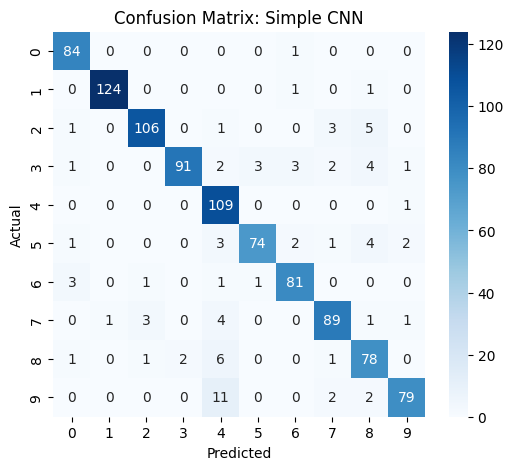

In [ ]:
# Train Simple CNN

# Define Simple CNN Architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 28x28 -> 14x14
        self.fc1 = nn.Linear(32 * 14 * 14, 10) # Flattened -> 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1) # Flatten
        x = self.fc1(x)
        return x

# Setup Model, Loss, Optimizer
model_cnn = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

# Training Loop
print("Starting CNN Training...")
start_time = time.time()

model_cnn.train()
for epoch in range(3): # 3 epochs
    for images, labels in cnn_train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

end_time = time.time()
cnn_time = end_time - start_time
print(f"CNN Training Time: {cnn_time:.2f} seconds")

# Evaluate
model_cnn.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in cnn_test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cnn_acc = correct / total
print(f"CNN Accuracy: {cnn_acc:.4f}")

# Visualizations
print("\nClassification Report (CNN):")
print(classification_report(all_labels, all_preds))

cm_cnn = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: Simple CNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



---



# Final Comparison: Accuracy vs. Efficiency
Finally, we conduct a comparative analysis of the two models. We visualize the trade-off between Accuracy and Training Time. This comparison highlights the difference between using heavy, pre-trained transformer models versus lightweight, custom-built CNNs.

/tmp/ipython-input-1410398997.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis', ax=ax[0])
/tmp/ipython-input-1410398997.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=times, palette='magma', ax=ax[1])


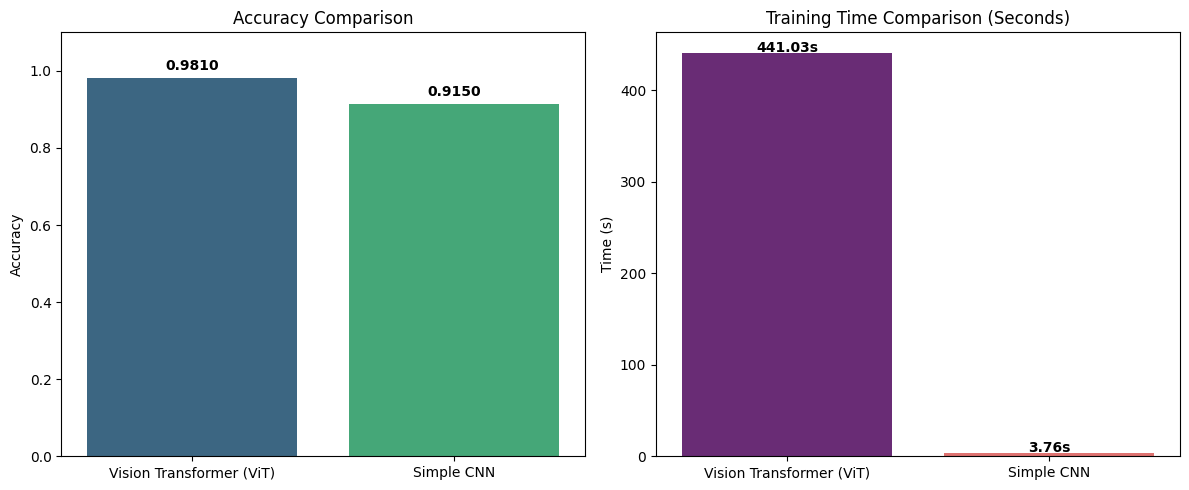

In [ ]:
# Final Comparison (ViT vs CNN)

models = ['Vision Transformer (ViT)', 'Simple CNN']
accuracies = [vit_acc, cnn_acc]
times = [vit_time, cnn_time]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot Accuracy
sns.barplot(x=models, y=accuracies, palette='viridis', ax=ax[0])
ax[0].set_title("Accuracy Comparison")
ax[0].set_ylabel("Accuracy")
ax[0].set_ylim(0, 1.1)
for i, v in enumerate(accuracies):
    ax[0].text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

# Plot Training Time
sns.barplot(x=models, y=times, palette='magma', ax=ax[1])
ax[1].set_title("Training Time Comparison (Seconds)")
ax[1].set_ylabel("Time (s)")
for i, v in enumerate(times):
    ax[1].text(i, v + 1, f"{v:.2f}s", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()



---



# Image Classification (ViT vs. CNN)

## Objective
This section explores the application of **Transformer architectures** in Computer Vision. We fine-tuned a pre-trained **Vision Transformer (ViT)** on the MNIST dataset and compared its performance against a traditional simple **Convolutional Neural Network (CNN)** baseline. The comparison focuses on **Accuracy** and **Computational Efficiency (Training Time)**.

## Methodology

### Dataset (MNIST Subset)
To ensure feasible training times within the Colab environment, we used a **fixed subset** of the MNIST dataset (selected sequentially):
* **Training:** 4,000 samples.
* **Testing:** 1,000 samples.

**Preprocessing:**
* **For ViT:** Images were upscaled from 28x28 to **224x224** and converted to **3 channels (RGB)** to match the pre-trained model's input requirements.
* **For CNN:** Images were kept in their original **28x28 Grayscale (1 channel)** format.
* **Normalization:** All images were normalized to pixel values in the range [0, 1].

### Models Implemented
1.  **Vision Transformer (ViT):** We fine-tuned `google/vit-base-patch16-224-in21k` (pre-trained on ImageNet-21k) for 3 epochs.
2.  **Simple CNN:** We implemented and trained a simple CNN architecture from scratch, consisting of **1 Convolutional layer**, followed by MaxPooling and a Fully Connected layer.

---

## Results

### Quantitative Comparison

| Metric | Vision Transformer (ViT) | Simple CNN | Observation |
| :--- | :--- | :--- | :--- |
| **Accuracy** | **98.10%** | 91.50% | ViT outperformed CNN by **+6.6%**. |
| **Training Time** | 441.03 sec (~7.3 min) | **3.76 sec** | CNN was **~117x faster** than ViT. |

### Confusion Matrix Analysis
* **ViT Performance:** The confusion matrix indicates exceptional precision. The model effectively distinguished between visually similar digits (like 4 and 9) with minimal errors.
* **CNN Performance:** While achieving good accuracy (>91%), the CNN showed slightly more confusion between specific digit pairs compared to the ViT.

---

## Discussion

1.  **Accuracy Dominance of ViT (Pre-training Benefit):**
    The ViT achieved near-perfect accuracy (**98.1%**) despite the small training subset (4000 images). This is largely because the model uses **Transfer Learning** (loaded from `google/vit-base-patch16-224-in21k`), leveraging features learned from millions of images. In contrast, the CNN was trained **from scratch**, limiting its ability to generalize from such a small dataset.

2.  **Efficiency Trade-off:**
    The CNN reached a respectable **91.5% accuracy** but trained **~117× faster** than the ViT. This highlights a clear trade-off: ViT provides state-of-the-art accuracy at a high computational cost, whereas the simple CNN offers extreme efficiency.

---

## Conclusion

This experiment demonstrates that **Vision Transformers (ViT)** are superior for tasks requiring maximum accuracy, especially when leveraging pre-trained weights. However, **lightweight CNNs** remain the optimal choice when computational resources are limited or when training speed is the priority.